# Importing the necessarry python packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import matplotlib as mpl
import glob
import matplotlib
from scipy.io import FortranFile
import struct
import os


current_dir   =   # Add the test suite path here
bin_dir       =   # Add the bin directory here
NUM_THREAD    = 8 # This depends on your machine, this is the number of threads you want to use with openmp

# Default compilation options for the tests

In [2]:
OPENMP     = 1    # We use the openmp speedup
SOLVER     = 2    # HLLD
SOLVERDUST = 0    # Huang & Bai 2021, if applicable ie if dust is included
RESOLUTION = 2048 # Default resolution for the 1D tests

default_compils={'OPENMP':OPENMP,"NUM_THREAD":NUM_THREAD,'SOLVER':SOLVER,'SOLVERDUST':SOLVERDUST,"RESOLUTION":RESOLUTION}

# Functions to read the data from shark

In [3]:
def read_var(filename,varname,size):
    f=open(filename+"/"+varname, "rb")
    dat = np.fromfile(f, dtype=np.float64, count=size, sep='')
    return dat

def read_parameter_file(fname="",evaluate=True,verbose=True,delimiter="="):
    # Read info file and create dictionary
    try:
        with open(fname) as f:
            content = f.readlines()
        f.close()
    except IOError:
        # Clean exit if the file was not found
        if verbose:
            print("File not found: "+fname)
        return 0
    infos={}
    for line in content:
        sp = line.split(delimiter)
        #print(sp)
        if len(sp) > 1:
            if evaluate:
                try:
                    infos[sp[0].strip()] = eval(sp[1].strip())
                except (NameError,SyntaxError):
                    infos[sp[0].strip()] = sp[1].strip()
            else:
                infos[sp[0].strip()] = sp[1].strip()
    return infos

def read_output(number,path='.'):
    
    if(number==-1):
        filelist = sorted(glob.glob(path+"/output*"))
        number = filelist[-1].split("_")[-1]
    print('Reading output '+str(number))
    data={}
    filename= path+"/output_"+ str(number).zfill(5)
    infos=read_parameter_file(fname=filename+'/info.dat')
    data['infos']=infos
    for key in infos:
        print(key+' = ',infos[key])
    
    NX          = infos["NX"]
    NY          = infos["NY"]
    NDUST       = infos["ndust"]
    GEOM        = infos['GEOM']
    GRIDSPACE   = infos['GRIDSPACE']
    CHARGING    = infos['charging']
    data['x']   = read_var(filename,'x',NX*NY)
    if(NY>1):
        data['y']   = read_var(filename,'y',NX*NY)
        data["xx"]  = np.linspace(np.amin(data["x"]),np.amax(data["x"]),NX)
        data["yy"]  = np.linspace(np.amin(data["y"]),np.amin(data["y"]),NY)
        data["xx"]  = np.linspace(0,1,NX)
        data["yy"]  = np.linspace(0,1,NY)
    
    vx   = read_var(filename,'v'  , NX*NY)
    vy   = read_var(filename,'vy' , NX*NY)
    P    = read_var(filename,'P'  , NX*NY)
    rho  = read_var(filename,'rho', NX*NY)

    if(NDUST>0):
        rhod   = read_var(filename,'rhod',  NX*NY*NDUST)
        vdx    = read_var(filename,'vd'  ,  NX*NY*NDUST)
        vdy    = read_var(filename,'vdy' ,  NX*NY*NDUST)
        if(CHARGING>0):
            ni = read_var(filename,'ni' , NX*NY)
            ne = read_var(filename,'ne' , NX*NY)
            eta_a = read_var(filename,'eta_a' , NX*NY)
            eta_o = read_var(filename,'eta_o' , NX*NY)
            eta_h = read_var(filename,'eta_h' , NX*NY)
        if(NDUST>1):
            for idust in range(NDUST):
                if(NY>1):
                    data['rhod'+str(idust+1)] = np.reshape(rhod[(idust)*NX*NY:(idust+1)*NX*NY],(NY,NX),order  = "C").T
                    data['vdx'+str(idust+1)]  = np.reshape(vdx[(idust) *NX*NY:(idust+1)*NX*NY],(NY,NX),order  = "C").T
                    data['vdy'+str(idust+1)]  = np.reshape(vdx[(idust) *NX*NY:(idust+1)*NX*NY],(NY,NX),order  = "C").T
                else:
                    data['rhod'+str(idust+1)] = rhod[(idust)* NX:(idust+1) * NX]
                    data['vdx'+str(idust+1)]  = vdx[(idust) * NX:(idust+1) * NX]
                    data['vdy'+str(idust+1)]  = vdy[(idust) * NX:(idust+1) * NX]
        else:
            if(NY>1):
                data['rhod'] = np.reshape(rhod,(NY,NX),order = "C").T
                data['vdx']  = np.reshape(vdx,(NY,NX),order = "C") .T
                data['vdy']  = np.reshape(vdy,(NY,NX),order = "C") .T               
            else:
                data['rhod'] = rhod
                data['vdx']  = vdx
                data['vdy']  = vdy
    if(NY>1):     
        data['rho'] = np.reshape(rho,(NY,NX),order = "C").T
        data['vx']  = np.reshape(vx ,(NY,NX),order = "C").T
        data['vy']  = np.reshape(vy ,(NY,NX),order = "C").T
        if(CHARGING):
            data['ni'] = np.reshape(ni,(NY,NX),order = "C").T
            data['ne'] = np.reshape(ne,(NY,NX),order = "C").T
            data['eta_a'] = np.reshape(eta_a,(NY,NX),order = "C").T
            data['eta_o'] = np.reshape(eta_o,(NY,NX),order = "C").T
            data['eta_h'] = np.reshape(eta_h,(NY,NX),order = "C").T     
    else:
        data['rho'] = rho
        data['vx']  = vx
        data['vy']  = vy
        data['P']   = P
        if(CHARGING>0):
            data['ni'] = ni
            data['ne'] = ne
            data['eta_a'] = eta_a
            data['eta_o'] = eta_o
            data['eta_h'] = eta_h        



    if(GEOM==2): 
        r=np.linspace(1,400,NX)
        if(GRIDSPACE==1):
            r=np.logspace(np.log10(1),np.log10(400),NX)
        data['r']=r
        data['theta']=np.linspace(0,2.*np.pi,NY)
    return data

# Functions to run the tests

In [16]:
def run_test(test='Sod-tube',path_suite=current_dir,options=default_compils,visu=True):
    
    if(test=="Sod-tube"):
        flags="SETUP=SOD NX="+str(default_compils["RESOLUTION"])+" NY=1 NGHOST=2 OPENMP="+str(default_compils["OPENMP"])+" DEBUG=0 SOLVER="+str(default_compils["SOLVER"])
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(current_dir+'/'+test)
        os.system(bin_dir+'/shark sod.nml')
        data_ana = np.loadtxt(current_dir+'/'+test+'/solution.dat')
        
        x_ana    = data_ana[:,1]
        rho_ana  = data_ana[:,3]
        u_ana    = data_ana[:,2]
        p_ana    = data_ana[:,4]
        T_ana    = data_ana[:,5]*1.2027e-8/2.5
        
        data=read_output(-1)
        plt.plot(x_ana,rho_ana,color='k',label='analytical solution')
        plt.plot(data['x'],data['rho'],color='r',linestyle='dashed',label='SHARK')
        plt.xlabel("x")
        plt.ylabel("density [code units]")
        plt.legend()
        plt.show()
        plt.plot(x_ana,u_ana,color='k',label='analytical solution')
        plt.plot(data['x'],data['vx'],color='r',linestyle='dashed',label='SHARK')
        plt.xlabel("x")
        plt.ylabel("Velocity [code units]")
        plt.legend()
        plt.show()
        os.chdir(current_dir)
        
    if(test=="DUSTYWAVE"):
        flags="SETUP=DUSTYWAVE NX="+str(default_compils["RESOLUTION"])+" NY=1 NDUST=1 NGHOST=2 OPENMP="+str(default_compils["OPENMP"])+" DEBUG=0 SOLVER="+str(default_compils["SOLVER"])
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(current_dir+'/'+test)
    
        #Wave with K = 1000
        os.system(bin_dir+'/shark wave1000.nml')
        data_ana    = np.loadtxt(current_dir+'/'+test+'/dustywave-K1000.dat')
        x_ana       = data_ana[:,0]
        vg_ana      = data_ana[:,1]
        vd_ana      = data_ana[:,2]
        rhog_ana    = data_ana[:,3]
        rhod_ana    = data_ana[:,4]
        data=read_output(-1)
        
        
        plt.plot(x_ana,vg_ana,color='k',label='analytical solution - Gas')
        plt.plot(data['x'],data['vx'],color='r',label='SHARK - Gas')
        plt.xlabel("x")
        plt.ylabel("Velocity gas [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()    
        
        plt.plot(x_ana,vd_ana,color='k',label='analytical solution - Dust')
        plt.plot(data['x'],data['vdx'],color='b',linestyle='dashed',label='SHARK - Dust')
        plt.xlabel("x")
        plt.ylabel("Velocity dust [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()        
        
        #Wave with K = 100
        os.system(bin_dir+'/shark wave100.nml')
        data_ana = np.loadtxt(current_dir+'/'+test+'/dustywave-K100.dat')
        x_ana       = data_ana[:,0]
        vg_ana      = data_ana[:,1]
        vd_ana      = data_ana[:,2]
        rhog_ana    = data_ana[:,3]
        rhod_ana    = data_ana[:,4]
        data=read_output(-1)
        
        
        plt.plot(x_ana,vg_ana,color='k',label='analytical solution - Gas')
        plt.plot(data['x'],data['vx'],color='r',label='SHARK - Gas')
        plt.xlabel("x")
        plt.ylabel("Velocity gas [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()    
        
        plt.plot(x_ana,vd_ana,color='k',label='analytical solution - Dust')
        plt.plot(data['x'],data['vdx'],color='b',linestyle='dashed',label='SHARK - Dust')
        plt.xlabel("x")
        plt.ylabel("Velocity dust [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()        
        
        #Wave with K = 50
        os.system(bin_dir+'/shark wave50.nml')
        data_ana = np.loadtxt(current_dir+'/'+test+'/dustywave-K50.dat')
        x_ana       = data_ana[:,0]
        vg_ana      = data_ana[:,1]
        vd_ana      = data_ana[:,2]
        rhog_ana    = data_ana[:,3]
        rhod_ana    = data_ana[:,4]
        data=read_output(-1)
        
        
        plt.plot(x_ana,vg_ana,color='k',label='analytical solution - Gas')
        plt.plot(data['x'],data['vx'],color='r',label='SHARK - Gas')
        plt.xlabel("x")
        plt.ylabel("Velocity gas [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()    
        
        plt.plot(x_ana,vd_ana,color='k',label='analytical solution - Dust')
        plt.plot(data['x'],data['vdx'],color='b',linestyle='dashed',label='SHARK - Dust')
        plt.xlabel("x")
        plt.ylabel("Velocity dust [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()        
        os.chdir(current_dir)
        
    if(test=="collapse"):
        flags="SETUP=Collapse_1D NX=128 NY=1 GEOM=1 GRAVITY=1 NDUST=0 NGHOST=2 OPENMP="+str(default_compils["OPENMP"])+" DEBUG=0 SOLVER="+str(default_compils["SOLVER"])
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(current_dir+'/'+test)
        os.system(bin_dir+'/shark collapse.nml')
        data=read_output(-1)
        plt.plot(np.log10(data['x']*data['infos']['unit_l']/1.5e13),np.log10(data['rho']),color='r')
        plt.xlabel("log R [au]")
        plt.ylabel("log density [gcc]")
        plt.legend()
        plt.show()
        os.chdir(current_dir)

    if(test=="dustycollapse"):
        flags="SETUP=Collapse_1D NX=128 NY=1 GEOM=1 GRAVITY=1 NDUST=10 NGHOST=2 OPENMP="+str(default_compils["OPENMP"])+" DEBUG=0 SOLVER=2 SOLVERDUST=0"
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(current_dir+'/'+test)
        os.system(bin_dir+'/shark collapse.nml')
        data=read_output(-1)
        plt.plot(np.log10(data['x']*data['infos']['unit_l']/1.5e13),np.log10(data['rho']),color='r',label='Gas')
        plt.xlabel("log R [au]")
        plt.ylabel("log density [gcc]")
        plt.legend()
        plt.show()  
        for idust in range(1,data['infos']['ndust']+1):  
            plt.plot(np.log10(data['x']*data['infos']['unit_l']/1.5e13),np.log10(data['rhod'+str(idust)]),color='b',linestyle='dashed',label='Dust size '+str(idust))
            plt.xlabel("log R [au]")
            plt.ylabel("log Dust density [gcc]")
        #plt.legend()
        plt.show()
        
        plt.plot(np.log10(data['rho']),np.log10(data['ni']),color='r',label = 'Ion')
        plt.plot(np.log10(data['rho']),np.log10(data['ne']),color='r',ls='dotted',label = 'Electrons')
        plt.xlabel("log R [au]")
        plt.ylabel("ne, ni [cm-3]")
        plt.legend()
        plt.show()
        
        plt.plot(np.log10(data['rho']),np.log10(data['eta_a']),color='r',label = 'Ambipolar')
        plt.plot(np.log10(data['rho']),np.log10(data['eta_o']),color='g',label = 'Ohm')
        plt.plot(np.log10(data['rho']),np.log10(data['eta_h']),color='g',label = 'Hall')
        plt.plot(np.log10(data['rho']),np.log10(-data['eta_h']),color='g',ls='dotted',label = 'Hall [negative part]')
        
        plt.xlabel("log R [au]")
        plt.ylabel("resistivities [s]")
        plt.legend()
        plt.show()
        os.chdir(current_dir)

    if(test=="SI_BA"):
        flags="SETUP=SI NX=64 NY=64 NDUST=1 NGHOST=2 OPENMP="+str(default_compils["OPENMP"])+" DEBUG=0 SOLVER=2 SOLVERDUST=0"
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        #os.system("make clean && make "+flags)
        os.chdir(current_dir+'/'+test)
        #os.system(bin_dir+'/shark si.nml')
        data=read_output(-1)
        fig,ax=plt.subplots(1,1)
        plt.contourf(data["xx"],data["yy"],np.log10(data["rhod"].T),levels=np.linspace(-2,1,100),cmap='magma',extend='both')
        plt.colorbar(label='Dust density [code unit]')
        plt.title('t = '+str(round(data["infos"]["time"],2))+' $\\Omega^{-1}$')
        plt.xlabel("x")
        plt.ylabel("y")
        #plt.legend()
        ax.set_aspect('equal')
        plt.show()
        plt.close("all")
        os.chdir(current_dir)


# Tests

## Test 1 : Sod-tube

This is the first test to be ran, this is a simple 1D simulation of a propagating shock. This test has an analytical solution and serves as a validation of the gas.

You are compiling with the options SETUP=SOD NX=2048 NY=1 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2
Reading output 00003
nvar =  5
ndust =  0
NX =  2048
NY =  1
MHD =  0
GEOM =  0
GRIDSPACE =  0
time =  0.245094188353975
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0
charging =  0


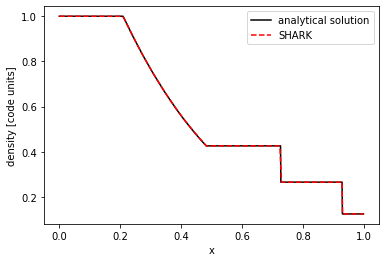

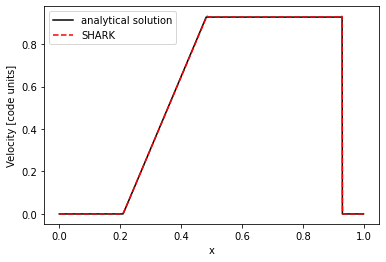

In [124]:
run_test(test='Sod-tube')

# Test 2 : Dustywave

Here we test the propagation of a gas & dust sound-wave or DUSTYWAVE. The drag between the gas and the dust generates a damping of the wave. The stronger the coupling is, the weaker the damping. Here we test 3 values for the drag coefficient K that controls the value of the stopping time : 50 (weak coupling), 100 (intermediate coupling) and 1000 (strong coupling). This test is 1D, but we compile the code with one dust species so we validate both the gas and the dust dynamics.

You are compiling with the options SETUP=DUSTYWAVE NX=2048 NY=1 NDUST=1 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2
Reading output 00004
nvar =  9
ndust =  1
NX =  2048
NY =  1
MHD =  0
GEOM =  0
GRIDSPACE =  0
time =  4.50000830935489
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0
charging =  0


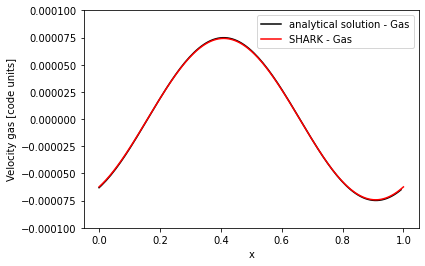

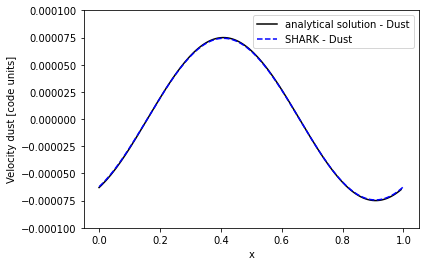

Reading output 00004
nvar =  9
ndust =  1
NX =  2048
NY =  1
MHD =  0
GEOM =  0
GRIDSPACE =  0
time =  4.5000437957155
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0
charging =  0


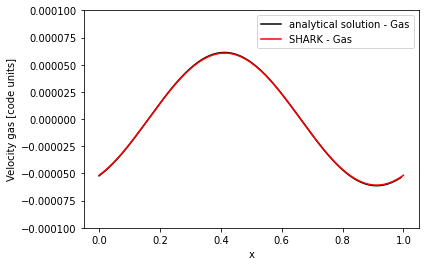

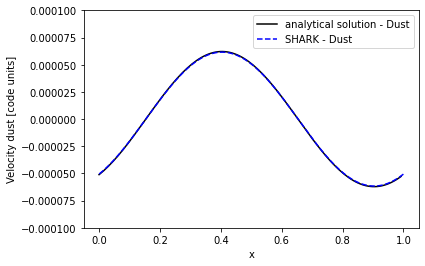

Reading output 00004
nvar =  9
ndust =  1
NX =  2048
NY =  1
MHD =  0
GEOM =  0
GRIDSPACE =  0
time =  4.50007778132959
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0
charging =  0


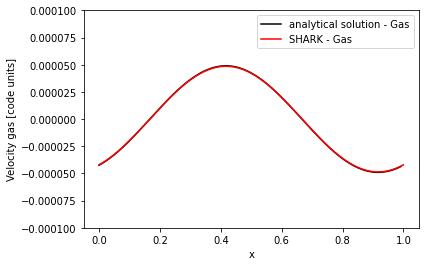

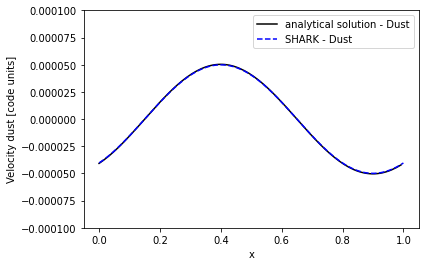

In [125]:
run_test(test='DUSTYWAVE')

# Test 3 : Collapse

This is to test a protostellar collapse calculation. This test does not have an analytical solution but we still know what to expect as protostellar collapses simulations have been run with many hydrodynamical code and with various numerical schemes.

You are compiling with the options SETUP=Collapse_1D NX=128 NY=1 GEOM=1 GRAVITY=1 NDUST=0 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reading output 00009
nvar =  5
ndust =  0
NX =  128
NY =  1
MHD =  0
GEOM =  1
GRIDSPACE =  0
time =  0.00035254232597767
unit_t =  1971391399391770.0
unit_d =  3.8577e-24
unit_l =  3e+18
unit_v =  1521.76782394687
unit_p =  8.933574128787e-18
charging =  0


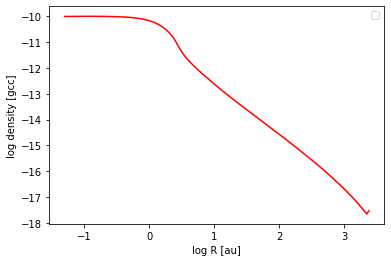

In [248]:
run_test(test='collapse')

# Test 4 : Dusty-collapse

You are compiling with the options SETUP=Collapse_1D NX=128 NY=1 GEOM=1 GRAVITY=1 NDUST=10 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2 SOLVERDUST=0
Reading output 00009
nvar =  45
ndust =  10
NX =  128
NY =  1
MHD =  0
GEOM =  1
GRIDSPACE =  0
time =  0.000350428341948101
unit_t =  1971391399391770.0
unit_d =  3.8577e-24
unit_l =  3e+18
unit_v =  1521.76782394687
unit_p =  8.933574128787e-18
charging =  1


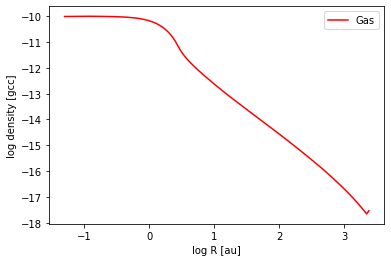

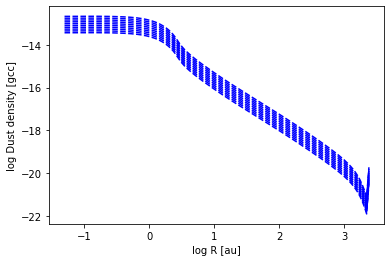

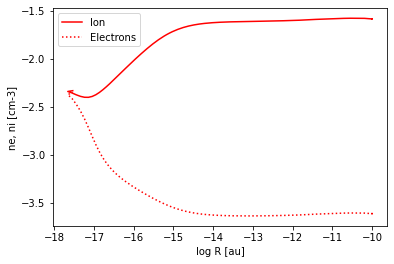

<ipython-input-252-f865cc379f28>:160: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(data['rho']),np.log10(data['eta_h']),color='g',label='Hall')
<ipython-input-252-f865cc379f28>:161: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(data['rho']),np.log10(-data['eta_h']),color='g',ls='dotted',label='Hall [negative part]')


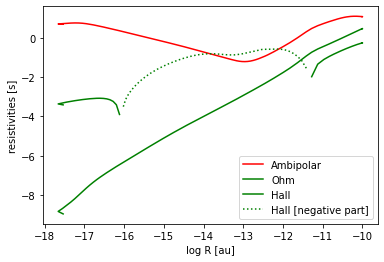

In [254]:
run_test(test='dustycollapse')

# Test 5 : Streaming instability BA test

This is the classical BA test from Johansen & Youdin 2007, only for the test we use a very low resolution to minimize the numerical coast since this is only a test. Fell free to increase the resolution at will to get nicer results.

You are compiling with the options SETUP=SI NX=64 NY=64 NDUST=1 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2 SOLVERDUST=0
Reading output 00011
nvar =  9
ndust =  1
NX =  64
NY =  64
MHD =  0
GEOM =  0
GRIDSPACE =  0
time =  500.00376679218
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0
charging =  0


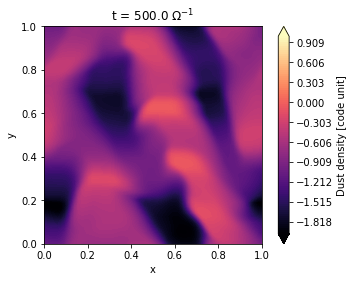

In [17]:
run_test(test='SI_BA')